### Import lib

In [1]:
import os
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from treeconfigparser import TreeConfigParser

import models.pw_reg as pwrg
from data.Data import Data

### Loss functions

In [2]:
def my_mse_1(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred-y_true)*(y_true))
def my_mse_2(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_pred-y_true)*(y_true+0.5))
def my_msle(y_true,y_pred):
    return tf.reduce_mean(tf.square(tf.math.log(y_pred+0.1)-tf.math.log(y_true+0.1)))

### Data generation

In [4]:
config_file = "nb/sim/cfg/pw-reg_pw.cfg"
config = TreeConfigParser()
config.readfiles(config_file)
data = Data(config)
data.prepare_input()
data.prepare_output()

mean, var xco2 402.15048 11.6537075
data.inp.train.shape[0] (13748, 160, 160, 1)


<bound method Data.prepare_output of Data(config=<treeconfigparser.TreeConfigParser object at 0x7fb110646e80>, shuffle_indices=None)>

### Model def

In [5]:
cb_best = keras.callbacks.ModelCheckpoint("nb/sim/weights/pw-reg_pw.h5", monitor="val_loss",
                                             save_weights_only=False, save_best_only=True)

In [8]:
model = pwrg.Unet_2(data.x.fields_input_shape, 1)
#model.compile('adam', loss=tf.keras.losses.MeanSquaredError())
model.compile('adam', loss=my_mse_1)
#model.compile('adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

2022-06-24 19:23:50.939390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-24 19:23:51.424346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14488 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


### Training

In [12]:
model.fit(x=data.x.train, y=data.y.train, epochs=3, 
          validation_data=(data.x.valid, data.y.valid))

Epoch 1/3


2022-06-24 19:24:27.975834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2022-06-24 19:24:28.426309: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


430/430 [==============================] - 37s 77ms/step - loss: 0.0462 - val_loss: 0.0175
Epoch 2/3
430/430 [==============================] - 31s 73ms/step - loss: 0.0223 - val_loss: 0.0131
Epoch 3/3
430/430 [==============================] - 31s 73ms/step - loss: 0.0167 - val_loss: 0.0101


In [ ]:
"""
model.compile('adam', loss=my_mse_2)
model.fit(x=data.x_train, y=data.y_train, epochs=3, callbacks = [cb_best], 
          validation_data=(data.x_valid, data.y_valid))
"""

In [13]:
model.compile('adam', loss=my_msle)
model.fit(x=data.x.train, y=data.y.train, epochs=10, callbacks = [cb_best], 
          validation_data=(data.x.valid, data.y.valid))

Epoch 1/10
430/430 [==============================] - 34s 77ms/step - loss: 0.2683 - val_loss: 0.2060
Epoch 2/10
430/430 [==============================] - 32s 74ms/step - loss: 0.1853 - val_loss: 0.1574
Epoch 3/10
430/430 [==============================] - 32s 74ms/step - loss: 0.1531 - val_loss: 0.1400
Epoch 4/10
430/430 [==============================] - 32s 74ms/step - loss: 0.1368 - val_loss: 0.1301
Epoch 5/10
430/430 [==============================] - 32s 74ms/step - loss: 0.1270 - val_loss: 0.1218
Epoch 6/10
430/430 [==============================] - 32s 74ms/step - loss: 0.1178 - val_loss: 0.1125
Epoch 7/10
430/430 [==============================] - 31s 73ms/step - loss: 0.1133 - val_loss: 0.1193
Epoch 8/10
430/430 [==============================] - 31s 73ms/step - loss: 0.1081 - val_loss: 0.1130
Epoch 9/10
430/430 [==============================] - 32s 74ms/step - loss: 0.1061 - val_loss: 0.1074
Epoch 10/10
430/430 [==============================] - 32s 74ms/step - loss: 0.102

## Evaluation

In [ ]:
#model = load_model(modelFile, custom_objects={ 'loss': penalized_loss(noise) })

In [ ]:
model = pwrg.Unet_2(1, data.Ny, data.Nx, data.N_input_channels)
model.load_weights("nb/sim/weights/pw-reg_pw.h5")
#model = keras.models.load_model("nb/sim/weights/pw-reg_pw.h5") 

mse: tf.Tensor(0.0010146967, shape=(), dtype=float32)


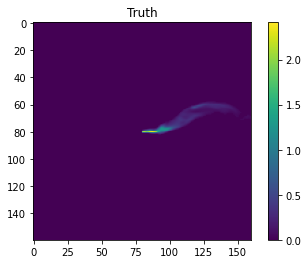

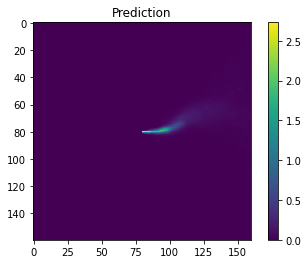

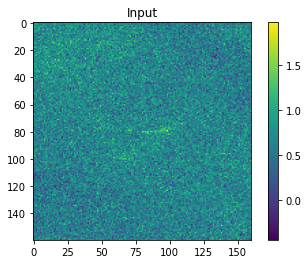

In [22]:
idx = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))

# error
y_true = np.squeeze(data.y.valid[idx])
y_pred = np.squeeze(model(tf.expand_dims(data.x.valid[0][idx], 0)))
mse = tf.keras.losses.MeanSquaredError()
error = mse(y_true=y_true, y_pred=y_pred)
print("mse:", error)

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
plt.colorbar()
plt.title("Truth")
plt.savefig("nb/sim/fig/reg_pw-truth.png", transparent=True)

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx], 0))[0]))
plt.colorbar()
plt.title("Prediction")
plt.savefig("nb/sim/fig/reg_pw-pred.png", transparent=True)

plt.figure()
plt.imshow(np.squeeze(data.x.valid[0][idx]))
plt.colorbar()
plt.title("Input")
plt.savefig("nb/sim/fig/reg_pw-input.png", transparent=True)

In [16]:
pred_valid = model.predict(tf.convert_to_tensor(data.x.valid[0], np.float32), batch_size=64)

In [17]:
pixels_pred =  np.squeeze(pred_valid.flatten()) + 0.01
pixels_truth = np.squeeze(data.y.valid.flatten()) + 0.01
pred_truth = pixels_pred/pixels_truth
df = pd.DataFrame({'y_true': pixels_truth, 'y_pred': pixels_truth, 
                   'pred/truth': pred_truth})

(0.0, 4.0)

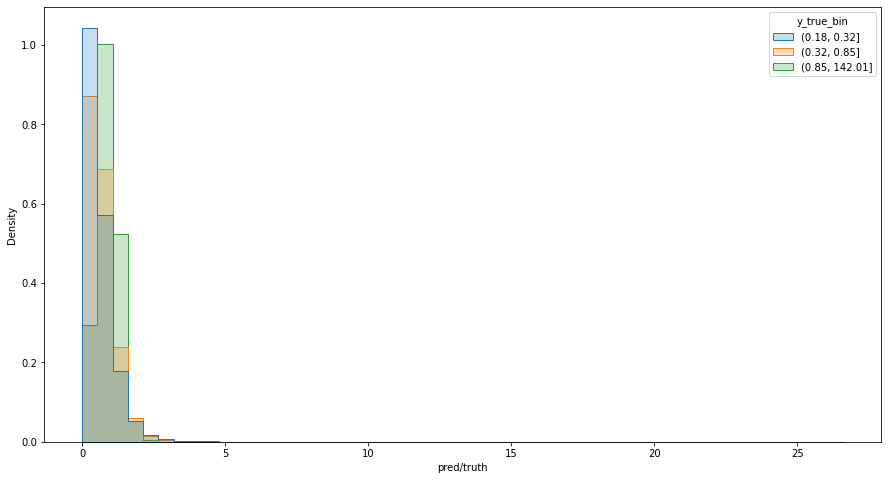

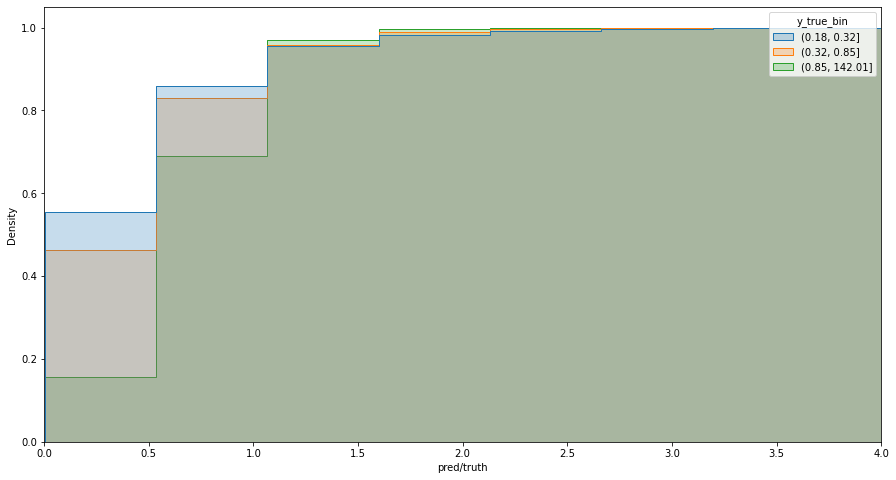

In [18]:
df["y_true_bin"] = pd.qcut(df["y_true"], q=[0.9,0.95,0.99, 1], precision=2)
plt.figure(figsize=(15,8))
sns.histplot(
    data=df,
    x="pred/truth",
    hue="y_true_bin",
    log_scale=False,
    element="step",
    #cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)
plt.figure(figsize=(15,8))
sns.histplot(
    data=df,
    x="pred/truth",
    hue="y_true_bin",
    log_scale=False,
    element="step",
    cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)
plt.xlim(0,4)